In [1]:
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import torch
from tqdm import tqdm
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
device = "cuda"

In [2]:
model_id = "meta-llama/Meta-Llama-3.1-8B"

# model_id = "openai-community/gpt2-large"

# model_id = "meta-llama/Llama-2-7b-hf"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
  model_id,
  device_map='auto',
  torch_dtype=torch.bfloat16,
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

Token indices sequence length is longer than the specified maximum sequence length for this model (289077 > 131072). Running this sequence through the model will result in indexing errors


In [4]:
max_length = min(model.config.max_position_embeddings, 4096)

stride = 512
seq_len = encodings.input_ids.size(1)

nlls = []
texts = []
tokens = []

char_norm_nlls = []

prev_end_loc = 0
for begin_loc in tqdm(range(0, seq_len, stride)):
    end_loc = min(begin_loc + max_length, seq_len)
    trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
    input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:, :-trg_len] = -100

    texts.append(tokenizer.decode(input_ids[0]))
    tokens.append(tokenizer.convert_ids_to_tokens(input_ids[0]))

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

        # loss is calculated using CrossEntropyLoss which averages over valid labels
        # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
        # to the left by 1.
        neg_log_likelihood = outputs.loss


    nlls.append(neg_log_likelihood)

    char_norm_nlls.append((trg_len-1) * neg_log_likelihood / len(texts[-1]))

    prev_end_loc = end_loc
    if end_loc == seq_len:
        break

 99%|█████████▊| 557/565 [10:38<00:09,  1.15s/it]


In [12]:
torch.exp(torch.stack(nlls).mean())

tensor(5.4206, device='cuda:0')

In [13]:
torch.stack(nlls).mean()

tensor(1.6902, device='cuda:0')

In [9]:
torch.stack(char_norm_nlls).mean()

tensor(0.0485, device='cuda:0')

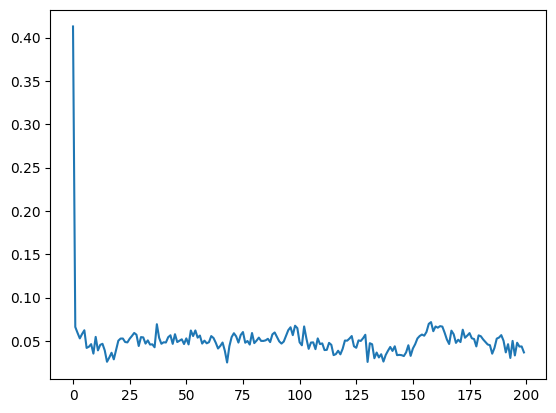

In [10]:
import matplotlib.pyplot as plt

plt.plot(torch.stack(char_norm_nlls).cpu().numpy()[:200])

(array([  2.,   0.,   0.,  10.,   9.,  35.,  32.,  62., 102.,  98.,  88.,
         54.,  36.,  22.,   6.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.01071814, 0.01473897, 0.01875979, 0.02278062, 0.02680144,
        0.03082226, 0.03484309, 0.03886391, 0.04288474, 0.04690556,
        0.05092638, 0.05494721, 0.05896803, 0.06298886, 0.06700968,
        0.0710305 , 0.07505133, 0.07907215, 0.08309298, 0.0871138 ,
        0.09113462, 0.09515545, 0.09917627, 0.

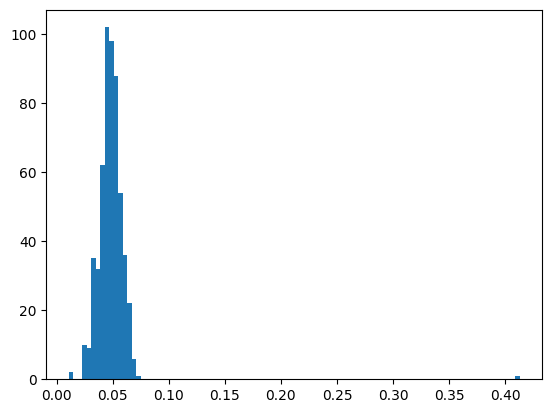

In [11]:
plt.hist([float(c) for c in char_norm_nlls], bins=100)